In [1]:
! which python3
! python3 -V

/Users/nick/Dev/magisterka/venv/bin/python3
Python 3.9.6


In [2]:
import typing as t
import jraph
import jax.numpy as jnp
import plotnine as gg
from jax import lax
import networkx as nx
import metadata
import haiku as hk
import utils
import jax
import optax

In [3]:
WINDOW = int(31*24*60/5)
VIS = False

In [4]:
def create_graph_tuple(senders, receivers, edges) -> jraph.GraphsTuple:
    return jraph.GraphsTuple(
        nodes=None,
        edges=edges,
        senders=senders,
        receivers=receivers,
        n_node=jnp.asarray([metadata.NUM_NODES]),
        n_edge=jnp.asarray([metadata.NUM_EDGES]),
        globals=None)

In [5]:
_senders = []
_receivers = []

for x, row in enumerate(metadata.ADJACENCY_MATRIX):
    for y, _ in enumerate(row):
        if metadata.ADJACENCY_MATRIX[x][y]:
            _senders.append(x)
            _receivers.append(y)

senders = jnp.array(_senders)
receivers = jnp.array(_receivers)
nodes = jnp.array([1] * metadata.NUM_NODES)
edges = jnp.array([1] * metadata.NUM_EDGES)

graph_features = jnp.array([[1]])
graph = create_graph_tuple(senders, receivers, edges)

if VIS:
    utils.draw_jraph_graph_structure(graph)

### Load data

In [6]:
import pandas as pd

In [7]:
df = pd.read_pickle("../data/samples_5m_subset_v1.pkl")

In [8]:
def get_data_for_link(src: str, dst: str, n: int) -> jnp.array:
    ss: pd.Series = df[(df["src_host"] == src) & (df["dst_host"] == dst)]
    return ss.incoming_rate_avg.to_numpy()[:n]

In [9]:
_map = metadata.NODE_IDS_TO_LABELS_MAPPING

_senders = []
_receivers = []
_edges = jnp.array([[]])

for x, row in enumerate(metadata.ADJACENCY_MATRIX):
    for y, _ in enumerate(row):
        if metadata.ADJACENCY_MATRIX[x][y]:
            _edges = jnp.append(_edges, 
                get_data_for_link(_map[x], _map[y], WINDOW))
                
            _senders.append(x)
            _receivers.append(y)

senders = jnp.array(_senders)
receivers = jnp.array(_receivers)
edges = jnp.array(_edges.reshape((metadata.NUM_EDGES, WINDOW)))

In [10]:
graph = create_graph_tuple(senders, receivers, edges)

In [11]:
if VIS:
    utils.draw_jraph_graph_structure(graph)

### Model

In [12]:
HIDDEN_SIZE = 256
LEARNING_RATE = 1e-4
SPLIT = 0.9
BLOCK_SIZE = int(24*60/5)  # 1 day
BATCH_SIZE = 32
SEED = 1237
NUM_TRAINING_STEPS = 1000

In [13]:
n = int(SPLIT * edges.shape[1])
d_train = edges[0][:n]
d_val = edges[0][n:]

In [14]:
d_train = jnp.log(d_train)
d_val = jnp.log(d_val)

In [15]:
d_val.shape, d_train.shape, edges.shape

((893,), (8035,), (15, 8928))

In [16]:
class TrainingState(t.NamedTuple):
    params: hk.Params
    opt_state: optax.OptState

class LoopValues(t.NamedTuple):
    tokens: jnp.ndarray
    state: t.Any
    rng_key: jnp.ndarray

Batch = t.Mapping[str, jnp.ndarray]

In [17]:
the_seed = hk.PRNGSequence(SEED)

def get_batch(split: str) -> Batch:
    data = d_train if split == "train" else d_val
    ixs = jax.random.randint(next(the_seed), (BATCH_SIZE, ), 0, len(data) - BLOCK_SIZE)
    x = jnp.stack([data[i:i+BLOCK_SIZE] for i in ixs])
    y = jnp.stack([data[i+1:i+BLOCK_SIZE+1] for i in ixs])
    return {'input': x, 'target': y}

In [18]:
expl_batch = get_batch("train")

In [19]:
def make_network() -> hk.Module:
    """Defines the network architecture."""
    model = hk.VanillaRNN(HIDDEN_SIZE)
    return model

def make_optimizer() -> optax.GradientTransformation:
    """Defines the optimizer."""
    return optax.adam(LEARNING_RATE)

In [20]:
def sequence_loss(batch: Batch) -> jnp.ndarray:
    """Unrolls the network over a sequence of inputs & targets, gets loss."""
    core = make_network()
    batch_size, sequence_length = batch['input'].shape  # (B, T) 

    initial_state = core.initial_state(batch_size)
    _input = jnp.expand_dims(batch['input'], -1) # (B, T, 1) 
    
    logits, _ = hk.dynamic_unroll(core, _input, initial_state, time_major=False)
    # logits -> (B, T, 1)
    loss = jnp.mean(jnp.square(logits[:, :, -1] - batch['target']))
    return loss

In [21]:
@jax.jit
def update(state: TrainingState, batch: Batch) -> TrainingState:
    """Does a step of SGD given inputs & targets."""
    _, optimizer = make_optimizer()
    _, loss_fn = hk.without_apply_rng(hk.transform(sequence_loss))
    gradients = jax.grad(loss_fn)(state.params, batch)
    updates, new_opt_state = optimizer(gradients, state.opt_state)
    new_params = optax.apply_updates(state.params, updates)
    return TrainingState(params=new_params, opt_state=new_opt_state)

In [22]:
rng = hk.PRNGSequence(SEED)

init_params_fn, loss_fn = hk.without_apply_rng(hk.transform(sequence_loss))
initial_params = init_params_fn(next(rng), expl_batch)
opt_init, _ = make_optimizer()
initial_opt_state = opt_init(initial_params)

# de facto initial state
state = TrainingState(params=initial_params, opt_state=initial_opt_state)

In [23]:
loss_fn = jax.jit(loss_fn)

In [24]:
state = update(state, expl_batch)

for step in range(NUM_TRAINING_STEPS):
    train_batch = get_batch("train")
    state = update(state, train_batch)

    if step % 50 == 0:
        eval_batch = get_batch("eval")
        loss = loss_fn(state.params, eval_batch)
        print({
            'step': step,
            'loss': float(loss),
        })

{'step': 0, 'loss': 26.954971313476562}
{'step': 50, 'loss': 1.9661026000976562}
{'step': 100, 'loss': 1.745630145072937}
{'step': 150, 'loss': 1.580053687095642}
{'step': 200, 'loss': 1.4514918327331543}
{'step': 250, 'loss': 1.323569893836975}
{'step': 300, 'loss': 1.2672549486160278}
{'step': 350, 'loss': 1.242878794670105}
{'step': 400, 'loss': 1.1497708559036255}
{'step': 450, 'loss': 1.121585726737976}
{'step': 500, 'loss': 1.1114641427993774}
{'step': 550, 'loss': 1.0418765544891357}
{'step': 600, 'loss': 1.1071653366088867}
{'step': 650, 'loss': 1.0555771589279175}
{'step': 700, 'loss': 1.085044264793396}
{'step': 750, 'loss': 1.0772420167922974}
{'step': 800, 'loss': 1.0577820539474487}
{'step': 850, 'loss': 1.1193467378616333}
{'step': 900, 'loss': 1.043343186378479}
{'step': 950, 'loss': 1.0217804908752441}


### Generating data from the model

In [25]:
def generate(
    context: jnp.ndarray,
) -> jnp.ndarray:
    """Draws samples from the model, given an initial context."""
    assert context.ndim == 1  # a single batch

    core = make_network()

    initial_state = core.initial_state(None)
    _input = jnp.expand_dims(context, 0) # (1, T) 
    logits, _ = hk.dynamic_unroll(core, _input, initial_state, time_major=False)
    return logits

In [26]:
_, sample_fn = hk.without_apply_rng(hk.transform(generate))
sample_fn = jax.jit(sample_fn)

(256, 288)


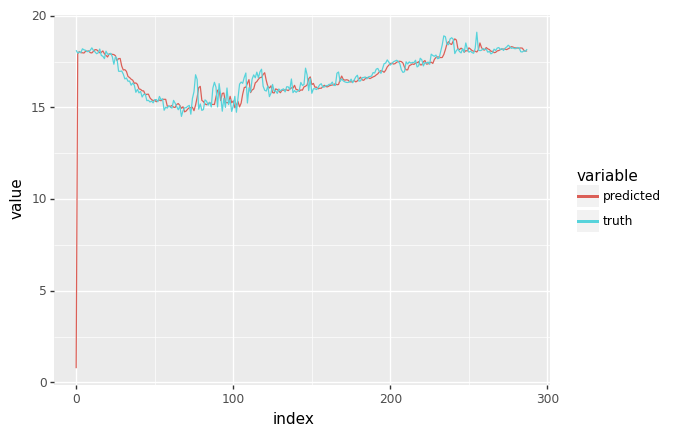

In [31]:
batch_id = 0

context = expl_batch['input'][0, :]
samples = sample_fn(state.params, context)

plot = utils.plot_samples(expl_batch['target'][0, :], samples[-1, :])
plot.draw()